# **Classification de tweets basée sur le transfert learning**

# Imports Packages

In [18]:
# Miscelaneous
import os
import sys
import re
import emoji
from string import punctuation
from unidecode import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')

# Keras
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, Conv1D, MaxPooling2D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as B

# Tensorflow
import tensorflow as tf

# SKLearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import shuffle

# Gensim
from gensim.models import KeyedVectors

# Mac Bug
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load Data

In [51]:
path = '../data/'
path_test = '../test/'
word2vec_path = path + 'GoogleNews-vectors-negative300.bin'
train_3_path = path + 'data_train_3.csv'
train_7_path = path + 'data_train_7.csv'
test_3_path = path + 'data_test_3.csv'

In [20]:
# Loading Data Set 3 Classes & Replacing Word 2 Int
train_3_data = pd.read_csv(train_3_path, encoding='utf-8', sep='\t', names=['id', 'class', 'text'])
conv_dict = {'neutral': 0, 'positive': 1, 'negative': -1}
train_3_data['class'] = train_3_data['class'].apply(lambda x: conv_dict[x])
display(train_3_data.head())
print(train_3_data.shape)

,id,class,text
0,260097528899452929,0,Won the match #getin . Plus\u002c tomorrow is ...
1,263791921753882624,0,Some areas of New England could see the first ...
2,264194578381410304,-1,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,0,#Thailand Washington - US President Barack Oba...
4,263816256640126976,0,Did y\u2019all hear what Tony Romo dressed up ...


(50333, 3)


In [21]:
test_3_data = pd.read_csv(test_3_path, encoding='utf-8', sep='\t', names=['id', 'class', 'text'])
conv_dict = {'neutral': 0, 'positive': 1, 'negative': -1}
test_3_data['class'] = test_3_data['class'].apply(lambda x: conv_dict[x])
display(test_3_data.head())
print(test_3_data.shape)

,id,class,text
0,264221473558917120,0,Manchester United will try to return to winnin...
1,264091690632105984,0,Going to a bulls game with Aaliyah & hope next...
2,263929564907069441,0,Any Toon Fans with a spare ticket for Anfield ...
3,263759328782204928,1,Louis inspired outfit on Monday and Zayn inspi...
4,259546192722161664,0,going to bed now...Rose parade then game tomorrow


(1020, 3)


In [22]:
# Loading Data Set 7 Classes
train_7_data = pd.read_csv(train_7_path, encoding='utf-8', sep='\t', names=['id', 'class', 'text'])
display(train_7_data.head())
print(train_7_data.shape)

,id,class,text
0,0,0,@liamch88 yeah! :) playing well
1,1,0,At least I don't have a guy trying to discoura...
2,2,0,UPLIFT: If you're still discouraged it means y...
3,3,0,"...at your age, the heyday in the blood is tam..."
4,4,-2,i was so embarrassed when she saw us i was lik...


(1630, 3)


# Preprocessing

In [23]:
smileys = {
  ":‑)": "smiley",
  ":-]": "smiley",
  ":-3": "smiley",
  ":->": "smiley",
  "8-)": "smiley",
  ":-}": "smiley",
  ":)": "smiley",
  ":]": "smiley",
  ":3": "smiley",
  ":>": "smiley",
  "8)": "smiley",
  ":}": "smiley",
  ":o)": "smiley",
  ":c)": "smiley",
  ":^)": "smiley",
  "=]": "smiley",
  "=)": "smiley",
  ":-))": "smiley",
  ":‑D": "smiley",
  "8‑D": "smiley",
  "x‑D": "smiley",
  "X‑D": "smiley",
  ":D": "smiley",
  "8D": "smiley",
  "xD": "smiley",
  "XD": "smiley",
  ">:D": "smiley",
  ":‑(": "sad",
  ":‑c": "sad",
  ":‑<": "sad",
  ":‑[": "sad",
  ":(": "sad",
  ":c": "sad",
  ":<": "sad",
  ":[": "sad",
  ":-||": "sad",
  ">:[": "sad",
  ":{": "sad",
  ":@": "sad",
  ">:(": "sad",
  ":'‑(": "sad",
  ":'(": "sad",
  ":‑P": "playful",
  "X‑P": "playful",
  "x‑p": "playful",
  ":‑p": "playful",
  ":‑Þ": "playful",
  ":‑þ": "playful",
  ":‑b": "playful",
  ":P": "playful",
  "XP": "playful",
  "xp": "playful",
  ":p": "playful",
  ":Þ": "playful",
  ":þ": "playful",
  ":b": "playful",
  "<3": "love"
}

contractions = {
  "ain't": "is not",
  "amn't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "'cause": "because",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "could've": "could have",
  "daren't": "dare not",
  "daresn't": "dare not",
  "dasn't": "dare not",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "e'er": "ever",
  "em": "them",
  "everyone's": "everyone is",
  "finna": "fixing to",
  "gimme": "give me",
  "gonna": "going to",
  "gon't": "go not",
  "gotta": "got to",
  "hadn't": "had not",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'll": "he will",
  "he's": "he is",
  "he've": "he have",
  "how'd": "how would",
  "how'll": "how will",
  "how're": "how are",
  "how's": "how is",
  "I'd": "I would",
  "I'll": "I will",
  "I'm": "I am",
  "I'm'a": "I am about to",
  "I'm'o": "I am going to",
  "isn't": "is not",
  "it'd": "it would",
  "it'll": "it will",
  "it's": "it is",
  "I've": "I have",
  "kinda": "kind of",
  "let's": "let us",
  "mayn't": "may not",
  "may've": "may have",
  "mightn't": "might not",
  "might've": "might have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "must've": "must have",
  "needn't": "need not",
  "ne'er": "never",
  "o'": "of",
  "o'er": "over",
  "ol'": "old",
  "oughtn't": "ought not",
  "shalln't": "shall not",
  "shan't": "shall not",
  "she'd": "she would",
  "she'll": "she will",
  "she's": "she is",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "should've": "should have",
  "somebody's": "somebody is",
  "someone's": "someone is",
  "something's": "something is",
  "that'd": "that would",
  "that'll": "that will",
  "that're": "that are",
  "that's": "that is",
  "there'd": "there would",
  "there'll": "there will",
  "there're": "there are",
  "there's": "there is",
  "these're": "these are",
  "they'd": "they would",
  "they'll": "they will",
  "they're": "they are",
  "they've": "they have",
  "this's": "this is",
  "those're": "those are",
  "'tis": "it is",
  "'twas": "it was",
  "wanna": "want to",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we're": "we are",
  "weren't": "were not",
  "we've": "we have",
  "what'd": "what did",
  "what'll": "what will",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "where'd": "where did",
  "where're": "where are",
  "where's": "where is",
  "where've": "where have",
  "which's": "which is",
  "who'd": "who would",
  "who'd've": "who would have",
  "who'll": "who will",
  "who're": "who are",
  "who's": "who is",
  "who've": "who have",
  "why'd": "why did",
  "why're": "why are",
  "why's": "why is",
  "won't": "will not",
  "wouldn't": "would not",
  "would've": "would have",
  "y'all": "you all",
  "you'd": "you would",
  "you'll": "you will",
  "you're": "you are",
  "you've": "you have",
  "Whatcha": "What are you",
  "luv": "love",
  "sux": "sucks"
}

In [24]:
tknzr = TweetTokenizer()
notstopwords = set(('not', 'no'))
my_stopwords = set(stopwords.words('english')) - notstopwords

def standardization(tweet):
    # Hashtag & Tag & URL & Unicode
    tweet = re.sub(r'(\\u[0-9A-Fa-f]+)', ' ', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"@\w+", '', tweet)
    tweet = re.sub(r"#\w+", '', tweet)
    
    # Tokenizer
    tknzr = TweetTokenizer()
    tweet = tknzr.tokenize(tweet)
    
    # Emojis
    tweet = [smileys[i] if i in smileys else i for i in tweet]
    tweet = ' '.join(tweet)
    
    # Lower
    tweet = tweet.lower()

    # Tokenizing & Stopwords
    tweet = tknzr.tokenize(tweet)
    tweet = [i for i in tweet if (i not in my_stopwords) and (i not in punctuation)]
    tweet = [contractions[i] if i in contractions else i for i in tweet]

    return tweet

In [25]:
# Applying Standardization
train_3_data['text'] = train_3_data['text'].apply(standardization)
test_3_data['text'] = test_3_data['text'].apply(standardization)
train_7_data['text'] = train_7_data['text'].apply(standardization)

In [26]:
# Fitting Tokenizer & Calculating Max Seq Length
all_tweets = train_3_data['text'].append(train_7_data['text']).append(test_3_data['text'])
MAX_SEQUENCE_LENGTH = int(all_tweets.str.len().max() * 0.75)
tokenizer = Tokenizer(filters=' ')
tokenizer.fit_on_texts(all_tweets)
word_index = tokenizer.word_index

In [27]:
# Applying Text To Sequences
train_3_data['text'] = tokenizer.texts_to_sequences(train_3_data['text'])
test_3_data['text'] = tokenizer.texts_to_sequences(test_3_data['text'])
train_7_data['text'] = tokenizer.texts_to_sequences(train_7_data['text'])

In [28]:
# Applying Padding
train_3_data['text'] = train_3_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])
test_3_data['text'] = test_3_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])
train_7_data['text'] = train_7_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])

In [29]:
class DataGenerator:
    def __init__(self, df, word2vec, max_size, nb_classes, batch_size):
        self.df = df
        self.word2vec = word2vec
        self.max_size = max_size
        self.nb_classes = nb_classes
        self.data_set_size = len(df)
        self.batch_size = batch_size
        self.step = len(df) // batch_size + (1 if self.data_set_size % self.batch_size else 0)

    def getXAt(self, index):
        return np.array(self.df.iloc[index]['text'])

    def getYAt(self, index):
        res = np.zeros(self.nb_classes)
        res[self.nb_classes // 2 + self.df.iloc[index]['class']] = 1
        return res

    def getWeights(self):
        WEIGHTS = {}
        nb_classes = []
        for i in range(self.nb_classes):
            nb_classes.append(self.df[self.df['class'] == (i - self.nb_classes // 2)].shape[0])
        for i in range(self.nb_classes):
            WEIGHTS[i] = max(nb_classes) / nb_classes[i]
        return WEIGHTS

    def getGenerator(self):
        while True:
            for idx in range(self.step):
                batch_x = np.array([self.getXAt(index) for index in range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.data_set_size))])
                batch_y = np.array([self.getYAt(index) for index in range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.data_set_size))])
                yield batch_x, batch_y

    def getInputGenerator(self):
        for idx in range(self.step):
            yield np.array([self.getXAt(index) for index in range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.data_set_size))])

In [30]:
# Word2Vec
EMBEDDING_DIM = 300
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [31]:
# Default Vector
default_vector = (np.random.rand(EMBEDDING_DIM) * 2.0) - 1
default_vector /= np.linalg.norm(default_vector)

# Number of words
nb_words = len(word_index) + 1

# Embeddings Matrix
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
cpt = 0
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    else:
        embedding_matrix[i] = default_vector
        cpt += 1
print('Embedding Matrix is empty at {}%'.format(100 * cpt / len(embedding_matrix)))

Embedding Matrix is empty at 40.590804701220335%


# Custom Metrics

In [32]:
def distance(y_true, y_pred):
    return B.square(B.argmax(y_true) - B.argmax(y_pred))

# Training

In [33]:
# Parameters
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 32
PATIENCE = 8
LR_PATIENCE = 3
train_df, val_df = train_test_split(train_3_data, test_size=0.2, random_state=1)
TRAINING_GENERATOR = DataGenerator(train_df, word2vec, MAX_SEQUENCE_LENGTH, 3, BATCH_SIZE)
VALIDATION_GENERATOR = DataGenerator(val_df, word2vec, MAX_SEQUENCE_LENGTH, 3, BATCH_SIZE)
WEIGHTS = TRAINING_GENERATOR.getWeights()
STEPS_PER_EPOCH = TRAINING_GENERATOR.step
VALIDATION_STEPS = VALIDATION_GENERATOR.step
print(WEIGHTS)

{0: 2.8995031255008814, 1: 1.0, 2: 1.1350944343351947}


In [ ]:
# Model Structure
model1 = Sequential()
model1.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, name='embedding_layer_model_1'))
model1.add(GRU(64))
model1.add(Dense(128, activation='relu', name='dense_1_model_1'))
model1.add(Dropout(0.1, name='drop_out_1_model_1'))
model1.add(Dense(3, activation='softmax', name='output_layer_model_1'))

# Summary
model1.summary()


# Callbacks and Summary
model1.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy', distance]
)
Callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=LR_PATIENCE, verbose=True),
             EarlyStopping(patience=PATIENCE, monitor='val_accuracy')]

# Training
history = model1.fit(TRAINING_GENERATOR.getGenerator(),
                     validation_data=VALIDATION_GENERATOR.getGenerator(),
                     epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                     validation_steps=VALIDATION_STEPS,
                     callbacks=Callbacks,
                     verbose=True)
                     #class_weight=WEIGHTS)

# Saving the Model
model1.save("{}{}".format(path, "model1.h5"))

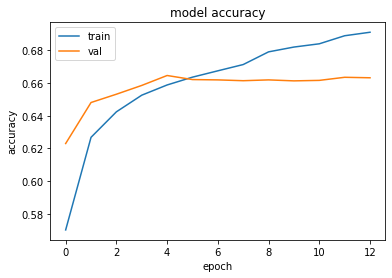

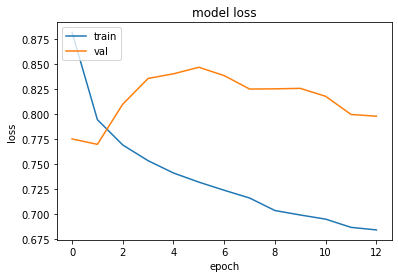

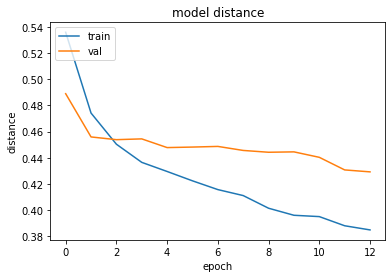

32/32 [==============================] - 0s 9ms/step
[0.7686548829078674, 0.6323529481887817, 0.5]
[[ 94  83  26]
 [ 27 311  91]
 [ 19 129 240]]


(array([-1,  0,  1]), array([140, 523, 357]))

In [67]:
# Plotting hist acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting hist loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting distance loss
plt.plot(history.history['distance'])
plt.plot(history.history['val_distance'])
plt.title('model distance')
plt.ylabel('distance')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Testing
TEST_GENERATOR = DataGenerator(test_3_data, word2vec, MAX_SEQUENCE_LENGTH, 3, BATCH_SIZE)
print(model1.evaluate(TEST_GENERATOR.getGenerator(), verbose=True, steps=TEST_GENERATOR.step))
y_pred = np.argmax(model1.predict(TEST_GENERATOR.getInputGenerator(), steps=TEST_GENERATOR.step), axis=1) - 1
y_true = test_3_data['class']
print(confusion_matrix(y_true, y_pred))
np.unique(y_pred, return_counts=True)

# Best was [0.6292, 0.7058, 0.4147]

In [35]:
# Parameters
LEARNING_RATE = 0.01
BATCH_SIZE = 16
EPOCHS = 256
PATIENCE = 64
LR_PATIENCE = 8
train_df, test_df = train_test_split(train_7_data, test_size=0.25, random_state=4)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=4)
TRAINING_GENERATOR = DataGenerator(train_df, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
VALIDATION_GENERATOR = DataGenerator(val_df, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
WEIGHTS = TRAINING_GENERATOR.getWeights()
print(WEIGHTS)
STEPS_PER_EPOCH = TRAINING_GENERATOR.step
VALIDATION_STEPS = VALIDATION_GENERATOR.step

{0: 2.242424242424242, 1: 1.2758620689655173, 2: 4.054794520547945, 3: 1.0, 4: 1.9096774193548387, 5: 3.148936170212766, 6: 2.52991452991453}


In [36]:
# Model Structure
dependencies = {
     'distance': distance
}
model2 = load_model("{}{}".format(path, "model1.h5"), custom_objects=dependencies)
model2.pop()

for layer in model2.layers:
    layer.trainable = False

model2.add(Dense(64, activation='relu', name='dense_1_model_2'))
model2.add(Dense(7, activation='softmax', name='output_layer_model_2'))

# Summary
model2.summary()

# Callbacks & Optimizer
model2.compile(
    loss='categorical_crossentropy', #kullback_leibler_divergence
    optimizer=optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True),
    metrics=['accuracy', distance]
)
Callbacks=[EarlyStopping(patience=PATIENCE, monitor='val_accuracy', restore_best_weights=False),
           ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=LR_PATIENCE, verbose=True)]

# Training
history = model2.fit(TRAINING_GENERATOR.getGenerator(),
                     validation_data=VALIDATION_GENERATOR.getGenerator(),
                     epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                     validation_steps=VALIDATION_STEPS,
                     callbacks=Callbacks,
                     verbose=True,
                     class_weight=WEIGHTS)

# Saving the Model
model2.save("{}{}".format(path, "model2.h5"))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer_model_1 (Emb (None, 24, 300)           13324200  
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_1_model_1 (Dense)      (None, 128)               8320      
_________________________________________________________________
drop_out_1_model_1 (Dropout) (None, 128)               0         
_________________________________________________________________
dense_1_model_2 (Dense)      (None, 64)                8256      
_________________________________________________________________
output_layer_model_2 (Dense) (None, 7)                 455       
Total params: 13,481,387
Trainable params: 78,787
Non-trainable params: 13,402,600
_____________________________________

/Users/vincent/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/256
69/69 [==============================] - 2s 27ms/step - loss: 3.3573 - accuracy: 0.1811 - distance: 4.5369 - val_loss: 1.5258 - val_accuracy: 0.3415 - val_distance: 4.2358
Epoch 2/256
69/69 [==============================] - 1s 13ms/step - loss: 3.1627 - accuracy: 0.2666 - distance: 3.2402 - val_loss: 1.5375 - val_accuracy: 0.3252 - val_distance: 3.8618
Epoch 3/256
69/69 [==============================] - 1s 16ms/step - loss: 3.1502 - accuracy: 0.2675 - distance: 3.1338 - val_loss: 1.5422 - val_accuracy: 0.3333 - val_distance: 3.7724
Epoch 4/256
69/69 [==============================] - 1s 13ms/step - loss: 3.1213 - accuracy: 0.2994 - distance: 2.9509 - val_loss: 1.5443 - val_accuracy: 0.3415 - val_distance: 3.6504
Epoch 5/256
69/69 [==============================] - 1s 16ms/step - loss: 3.1000 - accuracy: 0.2830 - distance: 3.1146 - val_loss: 1.5578 - val_accuracy: 0.3415 - val_distance: 3.6829
Epoch 6/256
69/69 [==============================] - 1s 13ms/step - loss: 3.0875

69/69 [==============================] - 1s 13ms/step - loss: 2.8449 - accuracy: 0.3867 - distance: 2.7170 - val_loss: 1.6675 - val_accuracy: 0.3089 - val_distance: 3.3984
Epoch 44/256
69/69 [==============================] - 1s 16ms/step - loss: 2.8439 - accuracy: 0.3849 - distance: 2.7707 - val_loss: 1.6663 - val_accuracy: 0.2927 - val_distance: 3.4390
Epoch 45/256
69/69 [==============================] - 1s 13ms/step - loss: 2.8607 - accuracy: 0.3985 - distance: 2.7398 - val_loss: 1.6681 - val_accuracy: 0.3008 - val_distance: 3.4309
Epoch 46/256
69/69 [==============================] - 1s 20ms/step - loss: 2.8218 - accuracy: 0.4076 - distance: 2.6606 - val_loss: 1.6674 - val_accuracy: 0.3008 - val_distance: 3.4309
Epoch 47/256
69/69 [==============================] - 1s 15ms/step - loss: 2.8351 - accuracy: 0.3822 - distance: 2.6187 - val_loss: 1.6706 - val_accuracy: 0.3008 - val_distance: 3.4309
Epoch 48/256
69/69 [==============================] - 1s 16ms/step - loss: 2.8542 - accu

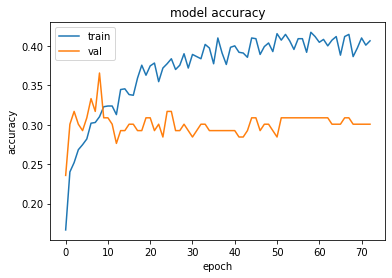

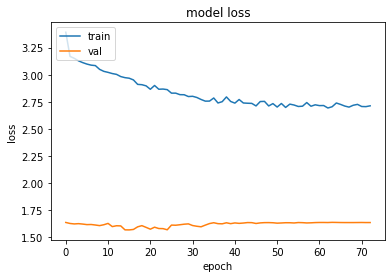

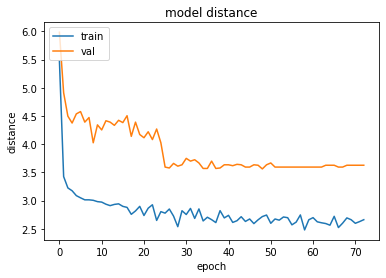

26/26 [==============================] - 0s 6ms/step
[1.5903987884521484, 0.3014705777168274, 3.1127450466156006]
[[25 13  4  8  2  0  1]
 [29 22 12 19  6  1  0]
 [ 8  5  9  4  1  2  0]
 [18 18 11 22 26  7 11]
 [ 4  7  2  8 19  7  6]
 [ 3  0  2  1  3  4 12]
 [ 0  2  4  1  9  8 22]]


(array([-3, -2, -1,  0,  1,  2,  3]), array([87, 67, 44, 63, 66, 29, 52]))

In [102]:
# Plotting hist acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting hist loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting distance loss
plt.plot(history.history['distance'])
plt.plot(history.history['val_distance'])
plt.title('model distance')
plt.ylabel('distance')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Testing the model
TEST_GENERATOR = DataGenerator(test_df, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
print(model2.evaluate(TEST_GENERATOR.getGenerator(), verbose=True, steps=TEST_GENERATOR.step))
y_pred = np.argmax(model2.predict(TEST_GENERATOR.getInputGenerator(), steps=TEST_GENERATOR.step), axis=1) - 3
y_true = np.array(test_df['class'])
print(confusion_matrix(y_true, y_pred))
np.unique(y_pred, return_counts=True)

# Best was [7.7098, 0.3112, 2.8504]

# Prediction

In [60]:
# Loading Data Set 7 Classes
predict_7_data = pd.read_csv(path + 'data_test_7_1.csv', encoding='utf-8', sep='\t')

# Rename Ugly Col Names
predict_7_data = predict_7_data.rename(columns={"Tweet": "text", "Intensity Class": "class"})
predict_7_data['class'] = predict_7_data['class'].apply(lambda x: int(x.split(':')[0]))

# Display
display(predict_7_data.head())
print(predict_7_data.shape)

# Preprocessing
predict_7_data['text'] = predict_7_data['text'].apply(standardization)
predict_7_data['text'] = tokenizer.texts_to_sequences(predict_7_data['text'])
predict_7_data['text'] = predict_7_data['text'].apply(lambda x: pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)[0])

# Display
display(predict_7_data.head())
print(predict_7_data.shape)

# Loading
dependencies = {'distance': distance}
model2 = load_model("{}{}".format(path, "best_model2.h5"), custom_objects=dependencies)

# Predicting
PREDICT_GENERATOR = DataGenerator(predict_7_data, word2vec, MAX_SEQUENCE_LENGTH, 7, BATCH_SIZE)
y_pred = np.argmax(model2.predict(PREDICT_GENERATOR.getInputGenerator(), steps=PREDICT_GENERATOR.step), axis=1) - 3
predict_7_data['class'] = y_pred
predict_7_data['text'] = predict_7_data['text'].apply(lambda _: 'Lost During Prediction')

# Display Results
display(predict_7_data.head())
with adlfs_client.open(path_test + 'result.csv', "wb") as f:
    predict_7_data.to_csv(f, sep='\t', index=False)

,ID,text,Affect Dimension,class
0,2018-En-02354,So @Ryanair site crashes everytime I try to bo...,valence,-3
1,2018-En-00124,Theme of week: Ask the Lord for strength &amp;...,valence,-2
2,2018-En-02603,"@F1 Why announcing so late, it will be hard to...",valence,-3
3,2018-En-00450,The greatest happiness is seeing someone you l...,valence,3
4,2018-En-00502,omg so grateful to have an education but ive b...,valence,1


(449, 4)


,ID,text,Affect Dimension,class
0,2018-En-02354,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1789, ...",valence,-3
1,2018-En-00124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111...",valence,-2
2,2018-En-02603,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",valence,-3
3,2018-En-00450,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 722, 2...",valence,3
4,2018-En-00502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 640, 921, 2401, 23...",valence,1


(449, 4)


,ID,text,Affect Dimension,class
0,2018-En-02354,Lost During Prediction,valence,-3
1,2018-En-00124,Lost During Prediction,valence,2
2,2018-En-02603,Lost During Prediction,valence,-3
3,2018-En-00450,Lost During Prediction,valence,3
4,2018-En-00502,Lost During Prediction,valence,2


NameError: name 'adlfs_client' is not defined